<a href="https://colab.research.google.com/github/shreya0202/Machine-Translation/blob/master/Machine_Translation_Group3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import required libraries

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k, IWSLT
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

# Torchtext 0.5.0 version is required

In [0]:
!pip install torchtext==0.5.0 

# Setting seed value to make sure the experiment reproduce similar results every time

In [0]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Download spacy model for German and English Languages


In [0]:
!python -m spacy download de
!python -m spacy download en

# Load the spacy model

In [0]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

# Create tokenizer function that returns list of tokens

In [0]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

# Declaring Fields

In [0]:
# Append <sos> to start of sentence and <eos> to end of sentence as well as convert each token to lowercase
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

# Read the data and apply preprocessing to text as declared in Fields

In [0]:

train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))


downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:02<00:00, 573kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 170kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 171kB/s]


# Build Source and Target Vocabulary

In [0]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

# set Device to GPU

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [0]:
device

device(type='cuda')

In [0]:
print('Total number of Training instances : ',len(train_data.examples))
print('Total number of Testing instances : ',len(test_data.examples))
print('Total number of Validation instances : ',len(valid_data.examples))

Total number of Training instances :  29000
Total number of Testing instances :  1000
Total number of Validation instances :  1014


In [0]:
train_sentences_en = []
train_sentences_de = []

for i in range(len(train_data.examples)):
    src = vars(train_data.examples[i])['src']
    src_sent = ' '.join(src)
    src_sent = src_sent.replace(' .', '.')
    src_sent = src_sent.replace(' ,', ',')
    src_sent = src_sent.replace(' :', ':')
    src_sent = src_sent.replace(' \'', '\'')
    src_sent = src_sent.replace(' \"', '\"')
    train_sentences_de.append(src_sent)
    
    trg = vars(train_data.examples[i])['trg']
    trg_sent = ' '.join(trg)
    trg_sent = trg_sent.replace(' .', '.')
    trg_sent = trg_sent.replace(' ,', ',')
    trg_sent = trg_sent.replace(' :', ':')
    trg_sent = trg_sent.replace(' \'', '\'')
    trg_sent = trg_sent.replace(' \"', '\"')
    train_sentences_en.append(trg_sent)

print('Total German sentences : ' + str(len(train_sentences_de)))
print('Total English sentences : ' + str(len(train_sentences_en)))

Total German sentences : 29000
Total English sentences : 29000


# Data Visualization

In [0]:
import pandas as pd
train_de = pd.DataFrame(train_sentences_de, columns=['sentence'])
train_en = pd.DataFrame(train_sentences_en, columns=['sentence'])

In [0]:
train_de['word_count'] = train_de['sentence'].apply(lambda x: len(str(x).split()))
train_de

,sentence,word_count
0,zwei junge weiße männer sind im freien in der ...,12
1,mehrere männer mit schutzhelmen bedienen ein a...,7
2,ein kleines mädchen klettert in ein spielhaus ...,9
3,ein mann in einem blauen hemd steht auf einer ...,14
4,zwei männer stehen am herd und bereiten essen zu.,9
...,...,...
28995,eine frau schreibt hinter einer verschnörkelte...,7
28996,ein bergsteiger übt an einer kletterwand.,6
28997,zwei bauarbeiter arbeiten auf einer straße vor...,9
28998,ein älterer mann sitzt mit einem jungen mit ei...,13


In [0]:
train_en['word_count'] = train_en['sentence'].apply(lambda x: len(str(x).split()))
train_en

,sentence,word_count
0,"two young, white males are outside near many b...",9
1,several men in hard hats are operating a giant...,11
2,a little girl climbing into a wooden playhouse.,8
3,a man in a blue shirt is standing on a ladder ...,14
4,two men are at the stove preparing food.,8
...,...,...
28995,a woman behind a scrolled wall is writing,8
28996,a rock climber practices on a rock climbing wall.,9
28997,two male construction workers are working on a...,12
28998,an elderly man sits outside a storefront accom...,15


Text(0, 0.5, 'Length')

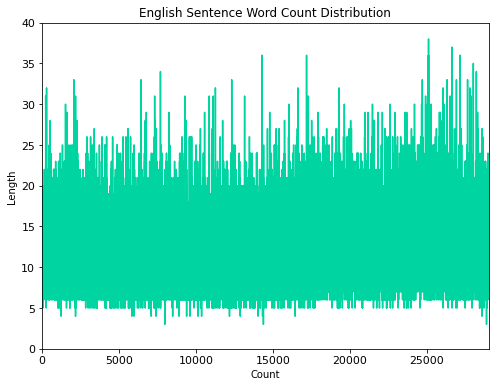

In [0]:
ax = train_en['word_count'].plot(
    figsize=(8,6),
    x='Count',
    y='Length',
    ylim=(0,40),
    kind='line',
    color='#00d5a1',
    fontsize=11,
    title='English Sentence Word Count Distribution')

ax.set_xlabel('Count')
ax.set_ylabel('Length')

In [0]:
print('Max. Sentence Length : ' + str(train_en['word_count'].max()))
print('Min. Sentence Length : ' + str(train_en['word_count'].min()))
print('Avg. Sentence Length : ' + str(train_en['word_count'].mean()))

Max. Sentence Length : 38
Min. Sentence Length : 3
Avg. Sentence Length : 11.994413793103448


# Generating Iterators

In [0]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

# Defining Transformer Architecture

In [0]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [0]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, src len]
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

In [0]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [0]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

In [0]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [0]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

In [0]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(3)
        
        #trg_pad_mask = [batch size, 1, trg len, 1]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

# Setting Hyper parameter values

In [0]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

# Initializing the Model

In [0]:
# Getting source and target padding index to avoid calculating gradients for it
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 7,713,740 trainable parameters


# Initializing model weights 

In [0]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)
        
model.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(5376, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): EncoderLayer(
        (lay

# Defining Optimizer for the model

In [0]:
LEARNING_RATE = 0.0001

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

# Defining Loss Function

In [0]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

# Training Method

In [0]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

# Evaluation Method

In [0]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [0]:
N_EPOCHS = 10
epochs = range(N_EPOCHS)
CLIP = 1

best_valid_loss = float('inf')

train_losses = []
val_losses = []

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '3_project_2_TT.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')


Epoch: 01 | Time: 0m 15s
	Train Loss: 5.462 | Train PPL: 235.559
	 Val. Loss: 4.052 |  Val. PPL:  57.489
Epoch: 02 | Time: 0m 15s
	Train Loss: 3.878 | Train PPL:  48.336
	 Val. Loss: 3.412 |  Val. PPL:  30.328
Epoch: 03 | Time: 0m 15s
	Train Loss: 3.418 | Train PPL:  30.505
	 Val. Loss: 3.059 |  Val. PPL:  21.316
Epoch: 04 | Time: 0m 15s
	Train Loss: 3.110 | Train PPL:  22.418
	 Val. Loss: 2.796 |  Val. PPL:  16.380
Epoch: 05 | Time: 0m 15s
	Train Loss: 2.865 | Train PPL:  17.554
	 Val. Loss: 2.586 |  Val. PPL:  13.273
Epoch: 06 | Time: 0m 15s
	Train Loss: 2.663 | Train PPL:  14.333
	 Val. Loss: 2.421 |  Val. PPL:  11.256
Epoch: 07 | Time: 0m 15s
	Train Loss: 2.494 | Train PPL:  12.113
	 Val. Loss: 2.300 |  Val. PPL:   9.975
Epoch: 08 | Time: 0m 15s
	Train Loss: 2.350 | Train PPL:  10.482
	 Val. Loss: 2.187 |  Val. PPL:   8.906
Epoch: 09 | Time: 0m 15s
	Train Loss: 2.224 | Train PPL:   9.243
	 Val. Loss: 2.091 |  Val. PPL:   8.093
Epoch: 10 | Time: 0m 15s
	Train Loss: 2.115 | Train PPL

# Plotting Loss for diffrent learning rates 

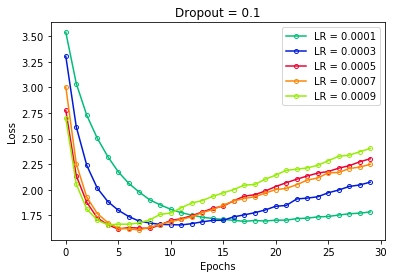

In [0]:
## Dropout = 0.1
# import matplotlib.pyplot as plt

# plt.plot(epochs, loss_0001, color='#00be77', marker='o', 
#          markersize=4,  fillstyle='none', label='LR = 0.0001')
# plt.plot(epochs, loss_0003, color='#001ad9', marker='o', 
#          markersize=4,  fillstyle='none', label='LR = 0.0003')
# plt.plot(epochs, loss_0005, color='#ee0231', marker='o', 
#          markersize=4,  fillstyle='none', label='LR = 0.0005')
# plt.plot(epochs, loss_0007, color='#fc8707', marker='o', 
#          markersize=4,  fillstyle='none', label='LR = 0.0007')
# plt.plot(epochs, loss_0009, color='#94ee02', marker='o', 
#          markersize=4,  fillstyle='none', label='LR = 0.0009')
# plt.legend(loc='upper right')
# plt.title('Dropout = 0.1')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.show()

# Loading and Testing saved model

In [0]:
model.load_state_dict(torch.load('3_project_2_TT.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 2.052 | Test PPL:   7.785 |


# Method for Single Sentence translation

In [0]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [0]:
example_idx = 2020

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'mann', 'in', 'violett', ',', 'weiß', 'und', 'gelb', 'auf', 'stelzen', '.']
trg = ['a', 'man', 'in', 'purple', ',', 'white', ',', 'and', 'yellow', 'on', 'stilts', '.']


In [0]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'man', 'in', 'white', ',', 'white', ',', 'and', 'yellow', 'on', 'yellow', 'on', '.', '<eos>']


# Define method to calculate BLEU score

In [0]:
from torchtext.data.metrics import bleu_score
from nltk.translate.bleu_score import corpus_bleu

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
#     return bleu_score(pred_trgs, trgs)
    return corpus_bleu(trgs, pred_trgs)

# Calulating BLEU Score for test set

In [0]:
start = time.time()
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)
stop = time.time()

mins, secs = epoch_time(start, stop)

print(f'BLEU score = {bleu_score*100:.2f}')
print('Time: {}m {}s'.format(mins, secs))

BLEU score = 29.17
Time: 0m 56s
